In [1]:
from collections import defaultdict
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns
from sklearn.model_selection import train_test_split

from dataset import load_dataset_from_path
from datasets import load_dataset, Dataset
from utils import partition_df

/cluster/home/kevidu/micromamba/envs/sftcontext/lib/python3.10/site-packages/transformers/utils/hub.py:127: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


In [2]:
ROOT_DATA_DIR = "../data/Arithmetic/"
RAW_DATA_PATH = os.path.join(ROOT_DATA_DIR, "arithmetic_dataset.csv")
df = load_dataset_from_path(RAW_DATA_PATH)
df = df.drop_duplicates(["query"])
df

,query_no_mod,query,prior_answer,context,ctx_answer,query_depth,ctx_depth
0,(2 * 4) - 3,(2 * 4) - 3 =,5,(2 * 4) - 3 = 9,9,2,2
1,((5 * 1) + 3) - 3,((5 * 1) + 3) - 3 =,5,3 = 7,5,3,0
2,(4 + 8) - 8,(4 + 8) - 8 =,4,8 = 3,4,2,0
3,2 + 0,2 + 0 =,2,0 = 4,6,1,0
4,(1 + 2) + 1,(1 + 2) + 1 =,4,1 = 4,10,2,0
...,...,...,...,...,...,...,...
4995,((0 - 0) * 6) * 1,((0 - 0) * 6) * 1 =,0,((0 - 0) * 6) * 1 = 7,7,3,3
4996,(3 * 2) - 3,(3 * 2) - 3 =,3,2 = 1,0,2,0
4997,(8 - 6) * 2,(8 - 6) * 2 =,4,2 = 7,14,2,0
4998,(0 - 2) + 8,(0 - 2) + 8 =,6,0 = 8,14,2,0


### EDA

In [3]:
df.value_counts(["query"])

query              
((0 * 0) * 3) + 8 =    1
(2 * 7) - 6 =          1
(2 + 0) * 4 =          1
(2 + 0) * 3 =          1
(2 + 0) * 2 =          1
                      ..
((5 - 1) * 3) - 3 =    1
((5 - 1) * 3) * 0 =    1
((5 - 0) - 6) + 6 =    1
((5 - 0) - 5) + 7 =    1
9 - 9 =                1
Name: count, Length: 5000, dtype: int64

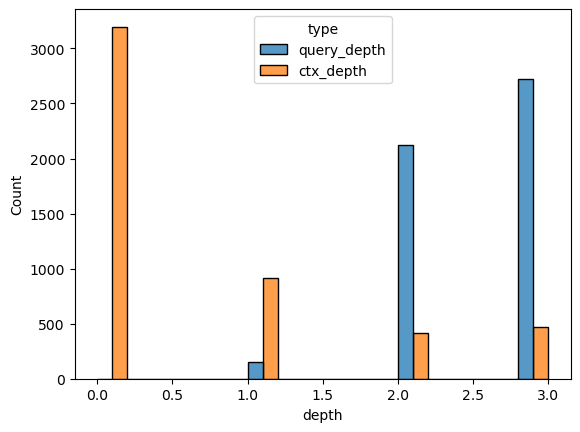

In [4]:
def plot_depth_dist(df):
    fig, ax = plt.subplots()
    sns.histplot(
        data=df.melt(id_vars="query", value_vars=["query_depth", "ctx_depth"], var_name="type", value_name="depth"), 
        x="depth",
        multiple='dodge',
        hue="type",
        ax=ax
    )
plot_depth_dist(df)
# Should we try to even this out more?

### Augment with intent

In [5]:
df_prior = df.copy()
df_prior["weight_context"] = 0
df_prior["answer"] = df_prior["prior_answer"]

df_ctx = df.copy()
df_ctx["weight_context"] = 1
df_ctx["answer"] = df_ctx["ctx_answer"]

df_all = pd.concat([df_prior, df_ctx], axis=0)
df_all.sort_values(["query", "context"])
df_all["answer"] = df_all["answer"].apply(str)
df_all["prior_answer"] = df_all["prior_answer"].apply(str)
df_all["ctx_answer"] = df_all["ctx_answer"].apply(str)

### Train/val/test split

In [6]:
train_df, val_df, test_df = partition_df(df_all, columns=["query"])
train_df = train_df.sort_values(["query", "context"])
val_df = val_df.sort_values(["query", "context"])
test_df = test_df.sort_values(["query", "context"])

train_df.info(), val_df.info(), test_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6400 entries, 1657 to 3255
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   query_no_mod    6400 non-null   object
 1   query           6400 non-null   object
 2   prior_answer    6400 non-null   object
 3   context         6400 non-null   object
 4   ctx_answer      6400 non-null   object
 5   query_depth     6400 non-null   int64 
 6   ctx_depth       6400 non-null   int64 
 7   weight_context  6400 non-null   int64 
 8   answer          6400 non-null   object
dtypes: int64(3), object(6)
memory usage: 500.0+ KB
<class 'pandas.core.frame.DataFrame'>
Index: 1600 entries, 688 to 846
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   query_no_mod    1600 non-null   object
 1   query           1600 non-null   object
 2   prior_answer    1600 non-null   object
 3   context         1600 non-null   o

(None, None, None)

In [7]:
train_df.value_counts("weight_context")

weight_context
0    3200
1    3200
Name: count, dtype: int64

In [8]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6400 entries, 1657 to 3255
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   query_no_mod    6400 non-null   object
 1   query           6400 non-null   object
 2   prior_answer    6400 non-null   object
 3   context         6400 non-null   object
 4   ctx_answer      6400 non-null   object
 5   query_depth     6400 non-null   int64 
 6   ctx_depth       6400 non-null   int64 
 7   weight_context  6400 non-null   int64 
 8   answer          6400 non-null   object
dtypes: int64(3), object(6)
memory usage: 500.0+ KB


In [9]:
full_dir = os.path.join(ROOT_DATA_DIR, "splits", "base")
os.makedirs(full_dir, exist_ok=True)
train_df.to_csv(
    os.path.join(full_dir, "train.csv"),
    index=False,
)
val_df.to_csv(
    os.path.join(full_dir, "val.csv"),
    index=False,
)
test_df.to_csv(
    os.path.join(full_dir, "test.csv"),
    index=False,
)

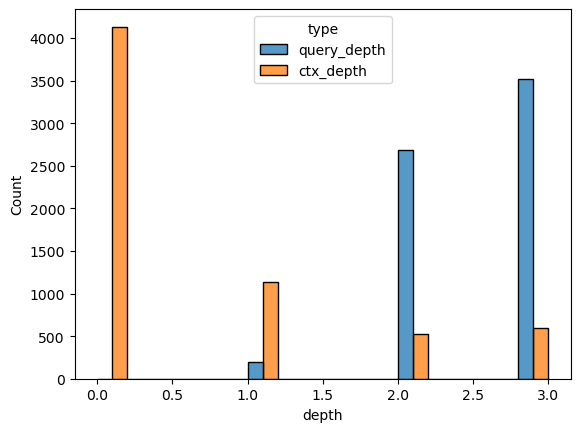

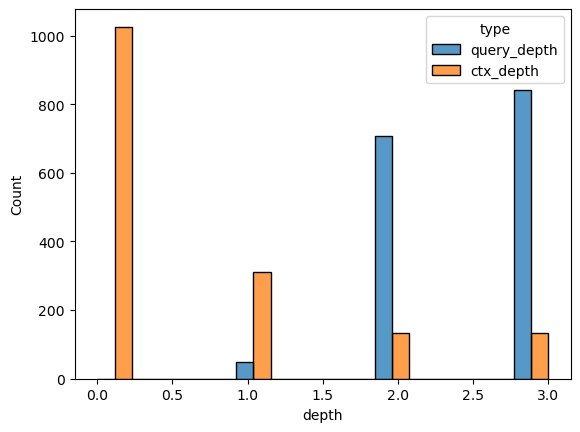

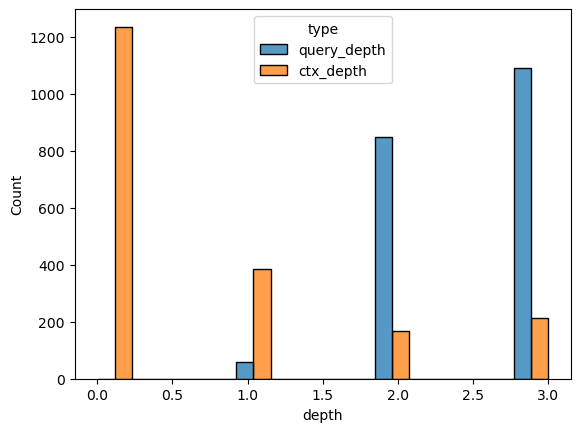

In [10]:
plot_depth_dist(train_df)
plot_depth_dist(val_df)
plot_depth_dist(test_df)
